In [1]:
from __future__ import print_function
from link_bot_notebooks import notebook_finder
from link_bot_notebooks import toy_problem_optimization_common as tpo
from link_bot_notebooks import linear_tf_model
import numpy as np
from itertools import cycle
import matplotlib.pyplot as plt
np.set_printoptions(precision=4, linewidth=120)

importing Jupyter notebook from /home/pmitrano/catkin_ws/src/link_bot/link_bot_notebooks/src/link_bot_notebooks/toy_problem_optimization_common.ipynb


In [2]:
dataset = "../../../link_bot_teleop/data/random_50_steps.txt"
goal = np.zeros((6,1))
n_steps = 50
data = tpo.load_train(dataset, n_steps=n_steps, N=6, L=2, extract_func=tpo.link_pos_vel_extractor2(6))
print(data.shape)

(51, 8, 250)


In [3]:
args = {'checkpoint': "log_data/init_A/December_10_23:11:39__0a0464776e/nn.ckpt-175000", 'log': False, 'batch_size': 1024}
dt = 0.1
x = tpo.load_train(dataset, N=6, L=2, n_steps=n_steps, extract_func=tpo.link_pos_vel_extractor2(6))
model = linear_tf_model.LinearTFModel(args, N=6, M=2, L=2, n_steps=50, dt=dt)
model.load()

INFO:tensorflow:Restoring parameters from log_data/init_A/December_10_23:11:39__0a0464776e/nn.ckpt-175000
Restored ckpt log_data/init_A/December_10_23:11:39__0a0464776e/nn.ckpt-175000 at step 175000


In [4]:
A = model.get_A()

In [5]:
def compare_predictions(example_idx):
    traj = data[:, :, example_idx]
    tf_s = traj[:1,:6].T
    tf_u = traj[:-1, [[6],[7]]]
    tf_o = model.predict_from_s(tf_s, tf_u)
    tf_s = np.linalg.lstsq(A, tf_o, rcond=None)[0]
    vx = traj[0][6]
    vy = traj[0][7]
    s = traj[0][[0, 1]]
    s_true = traj[n_steps][[0, 1]]
    s_expected = s + np.array([vx, vy]) * 0.1 * n_steps
    d_true = s_true - s
    d_expected = s_expected - s
    xy_error = s_true - s_expected
    no_dynamics_error = s_true - s
    tf_error = tf_s - s
    xy_error_d = np.linalg.norm(xy_error)
    no_dynamics_error_d = np.linalg.norm(no_dynamics_error)
    tf_error_d = np.linalg.norm(tf_error)
    print('distance error for xy model', xy_error_d)
    print('distance error for no dynamics model', no_dynamics_error_d)
    print('distance error for learned model', tf_error_d)
    if xy_error_d > no_dynamics_error_d:
        print("sad")
    if tf_error_d > no_dynamics_error_d:
        print("extra sad")
    if xy_error_d > tf_error_d:
        print("TF does better than XF")
    plt.figure()
    plt.title("example {}".format(example_idx))
    plt.scatter(s[0], s[1], s=100, c='r')
    plt.scatter(traj[0, 4], traj[0, 5], s=200, c='k')
    plt.plot(traj[:, 4], traj[:, 5], label='head')
    plt.scatter(traj[0, 2], traj[0, 3], s=200, c='y')
    plt.plot(traj[:, 2], traj[:, 3], label='middle')
    plt.plot(traj[:, 0], traj[:, 1], label='tail')
    plt.plot([s[0], s_expected[0]], [s[1], s_expected[1]], label='tail expected')
    plt.plot([s[0], tf_s[0]], [s[1], tf_s[1]], label='tail learned')
    plt.axis("equal")
    plt.legend();

distance error for xy model 1.1924106394382548
distance error for no dynamics model 3.9511739968031687
distance error for learned model 8.411484430103666
extra sad


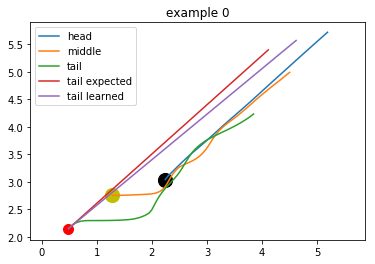

In [6]:
compare_predictions(0)

distance error for xy model 0.9343830296246345
distance error for no dynamics model 3.7521411372922104
distance error for learned model 9.52724580711769
extra sad


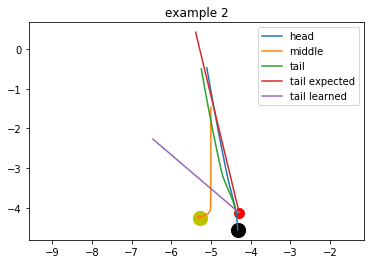

In [7]:
compare_predictions(2)

distance error for xy model 0.8583353647831673
distance error for no dynamics model 0.04738319456896004
distance error for learned model 7.94072742402354
sad
extra sad


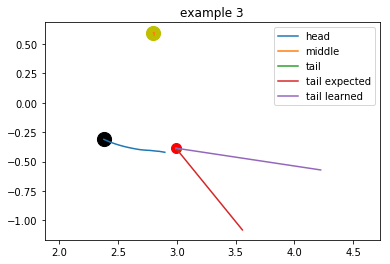

In [8]:
compare_predictions(3)

distance error for xy model 2.9614734397216482
distance error for no dynamics model 3.337584471032622
distance error for learned model 8.756728365004648
extra sad


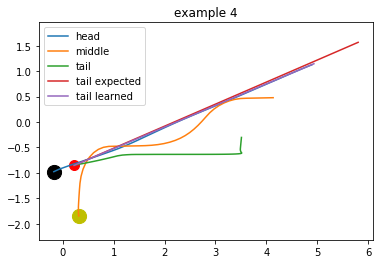

In [9]:
compare_predictions(4)

distance error for xy model 3.014662933925745
distance error for no dynamics model 3.5338792453492758
distance error for learned model 6.315743280240874
extra sad


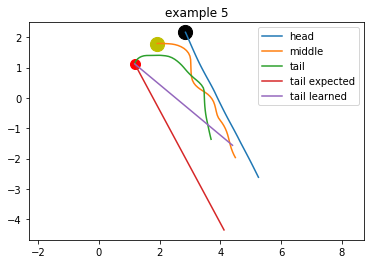

In [10]:
compare_predictions(5)

distance error for xy model 1.4829311932978861
distance error for no dynamics model 0.11335887485404512
distance error for learned model 8.65092585773891
sad
extra sad


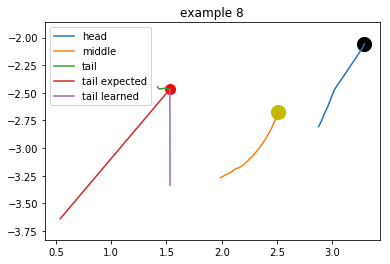

In [11]:
compare_predictions(8)

distance error for xy model 3.232852690065674
distance error for no dynamics model 4.114053822440712
distance error for learned model 10.168553500580881
extra sad


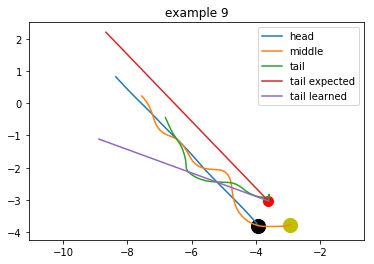

In [12]:
compare_predictions(9)

In [15]:
f = 0.0
m = 0
xy_error_sum = 0
no_dynamics_error_sum = 0
tf_error_sum = 0
for i in range(data.shape[2]):
    traj = data[:, :, i]
    tf_s = traj[:1,:6].T
    tf_u = traj[:-1, [[6],[7]]]
    tf_o = model.predict_from_s(tf_s, tf_u)
    vx = traj[0][6]
    vy = traj[0][7]
    o = traj[0][[0, 1]]
    o_true = traj[n_steps][[0, 1]]
    print(o_true)
    o_true_tf = model.reduce(traj[n_steps:,:6].T)
    o_expected = o + np.array([vx, vy]) * 0.1 * (n_steps - 0)
    d_true = o_true - o
    d_expected = o_expected - o
    xy_error = o_true - o_expected
    no_dynamics_error = o_true_tf - o
    tf_error = o_true - tf_o
    xy_error_d = np.linalg.norm(xy_error)
    no_dynamics_error_d = np.linalg.norm(no_dynamics_error)
    tf_error_d = np.linalg.norm(tf_error)
    xy_error_sum += xy_error_d
    no_dynamics_error_sum += no_dynamics_error_d
    tf_error_sum += tf_error_d
    
xy_loss = xy_error_sum/ data.shape[2]
no_dynamics_loss = no_dynamics_error_sum/ data.shape[2]
tf_loss = tf_error_sum/ data.shape[2]
print('loss of XY dynamics:', xy_loss)
print('loss of no dynamics:', no_dynamics_loss)
print('loss of TF dynamics:', tf_loss)
if xy_loss > no_dynamics_loss:
    print("VERY SAD.")
else:
    print("Success!!!")

[3.847  4.2327]
[8.4412 5.4818]
[-5.2443 -0.5   ]
[ 3.0373 -0.3976]
[ 3.5105 -0.3036]
[ 3.6906 -1.3623]
[ 2.2983 -4.6293]
[-4.8051 -5.5886]
[ 1.4197 -2.446 ]
[-6.8147 -0.4443]
[ 4.6665 -0.3081]
[-3.8964 -2.4609]
[ 0.6769 -2.3461]
[ 1.3261 -3.2064]
[ 3.2911 -4.9522]
[0.1748 0.9299]
[ 1.0311 -1.9251]
[6.134  1.4673]
[-4.595  -1.9568]
[0.3364 2.7813]
[3.5373 2.2623]
[3.9547 2.1314]
[-1.9711  3.2455]
[-2.9622  3.0894]
[ 2.2998 -3.282 ]
[-7.547 -4.182]
[ 3.0373 -0.8857]
[-1.8932 -1.1316]
[-3.3216 -1.8508]
[ 0.5681 -4.4895]
[ 4.9249 -2.2796]
[-3.5605 -1.5943]
[-3.1414  4.6098]
[-2.6432  0.1824]
[-2.2219  0.8633]
[-1.0472  0.7416]
[2.6896 2.525 ]
[-2.0785 -2.5917]
[-5.4108  1.6432]
[ 3.074  -0.3419]
[-2.0698  3.4894]
[-0.2136  0.2873]
[-5.6099 -2.1779]
[ 2.5092 -2.9109]
[ 2.2375 -4.71  ]
[-2.0787 -5.3068]
[-4.0437 -0.6988]
[-1.2015 -3.1885]
[-1.7367 -1.2641]
[-4.1986  4.0253]
[ 4.152  -4.4328]
[-4.1965 -1.0705]
[2.7202 1.9834]
[-1.8548  2.6729]
[-2.9351  0.9438]
[4.2478 1.663 ]
[0.1588 0.5847

In [14]:
d_sum = 0
for i in range(data.shape[2]):
    traj = data[:, :, i]
    vx = traj[0][6]
    vy = traj[0][7]
    s = traj[0][[0, 1]]
    s_true = traj[n_steps][[0, 1]]
    d_true = np.linalg.norm(s_true - s)
    d_sum += d_true
    
print("average displacement for random {} time-step actions: {}".format(n_steps, d_sum / data.shape[2]))

average displacement for random 50 time-step actions: 1.9752064385
